## Capstone 2

The goal of this capstone is to predict the insurance cost with age, bmi, children, and smoker.

## 1. Loading Libraries

In [1]:
#import libraries and packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm 
from statsmodels.graphics.api import abline_plot 
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import train_test_split 
from sklearn import linear_model, preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import  Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

## 2. Loading Data

In [2]:
#load in data
insurance = pd.read_csv("insurance.csv")

In [3]:
#checking data
insurance.head()

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

## 3. DATA CLEANING

In [4]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
insurance.shape

(1338, 7)

In [6]:
insurance.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [7]:
insurance.duplicated().sum()

1

In [8]:
insurance[insurance.duplicated(keep=False)]

age   sex    bmi  children smoker     region    charges
195   19  male  30.59         0     no  northwest  1639.5631
581   19  male  30.59         0     no  northwest  1639.5631

seems like there is 1 duplcate, let's drop it

In [9]:
df = insurance.drop_duplicates()
df.duplicated().sum()

0

Now that there is no more duplcaites, I am going to add a new feature "bmi_cat" from "bmi" based on a standard range.

In [10]:
def bmi_to_cat(bmi:float) -> str:
    if bmi<18.5:
        return 'Underweight'
    elif 18.5<=bmi<25:
        return 'Normal weight'
    elif 25<=bmi<30:
        return 'Overweight'
    elif 30<=bmi<35:
        return 'Obese'
    elif 35<=bmi<40:
        return 'Severely Obese'
    elif 40<=bmi:
        return 'Morbidly Obese'

df.insert(3,'bmi_cat',df['bmi'].apply(bmi_to_cat))
df.head()

age     sex     bmi        bmi_cat  children smoker     region      charges
0   19  female  27.900     Overweight         0    yes  southwest  16884.92400
1   18    male  33.770          Obese         1     no  southeast   1725.55230
2   28    male  33.000          Obese         3     no  southeast   4449.46200
3   33    male  22.705  Normal weight         0     no  northwest  21984.47061
4   32    male  28.880     Overweight         0     no  northwest   3866.85520

## 4. EDA

array([[<AxesSubplot:title={'center':'charges'}>]], dtype=object)

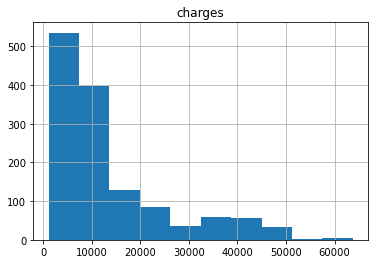

In [11]:
df.hist(column='charges', bins=10)

In [12]:
df.charges.describe()

count     1337.000000
mean     13279.121487
std      12110.359656
min       1121.873900
25%       4746.344000
50%       9386.161300
75%      16657.717450
max      63770.428010
Name: charges, dtype: float64

array([[<AxesSubplot:title={'center':'age'}>]], dtype=object)

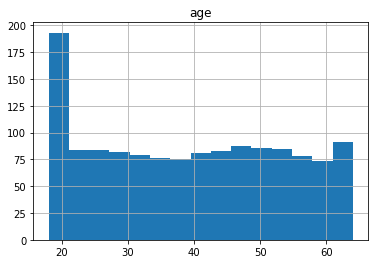

In [13]:
df.hist(column='age', bins=15)

Lowest charge = $1121. Customer is range from 18 - 64. Most patiences are at age 20.

In [14]:
pd.crosstab(df.sex, df.smoker, margins = True)

smoker    no  yes   All
sex                    
female   547  115   662
male     516  159   675
All     1063  274  1337

Female and Male are approx. equal in population.

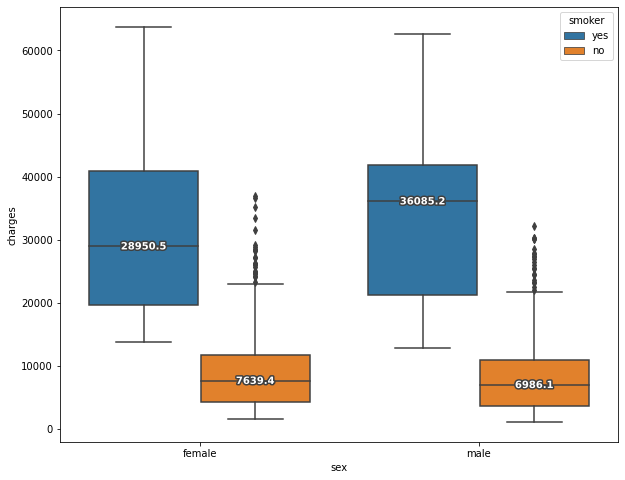

In [15]:
import matplotlib.patheffects as path_effects
def add_median_labels(ax, fmt='.1f'):
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    for median in lines[4:len(lines):lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
        text = ax.text(x, y, f'{value:{fmt}}', ha='center', va='center',
                       fontweight='bold', color='white')
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground=median.get_color()),
            path_effects.Normal(),
        ])

fig, ax = plt.subplots(figsize=(10, 8))
fig = sns.boxplot(data = df, x = 'sex', y = 'charges', hue = 'smoker', ax = ax)

add_median_labels(ax)
plt.show()

there is a significant difference in medical expenses between smokers and non-smokers. While the median for non-smokers is 7300 dollars, the median for smokers is close to 32000 dollars.

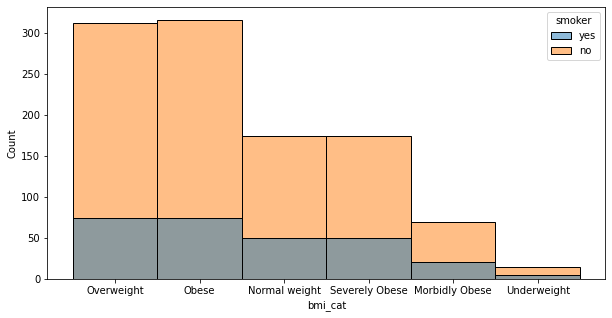

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data = df, x='bmi_cat', hue = 'smoker', ax = ax)
plt.show()

In [17]:
pd.crosstab(df.region, df.bmi_cat, margins = True)

bmi_cat    Morbidly Obese  Normal weight  Obese  Overweight  Severely Obese  \
region                                                                        
northeast              15             73     90          98              38   
northwest               8             63    104         107              35   
southeast              55             41     94          80              94   
southwest              13             48    102         101              58   
All                    91            225    390         386             225   

bmi_cat    Underweight   All  
region                        
northeast           10   324  
northwest            7   324  
southeast            0   364  
southwest            3   325  
All                 20  1337

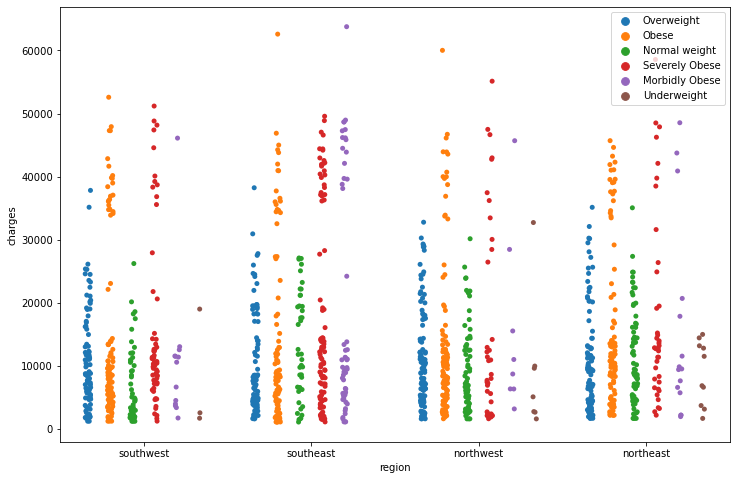

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sns.stripplot(data = df, x = "region", y = "charges", hue = "bmi_cat", dodge=True)
plt.legend(loc='upper right')
plt.show()

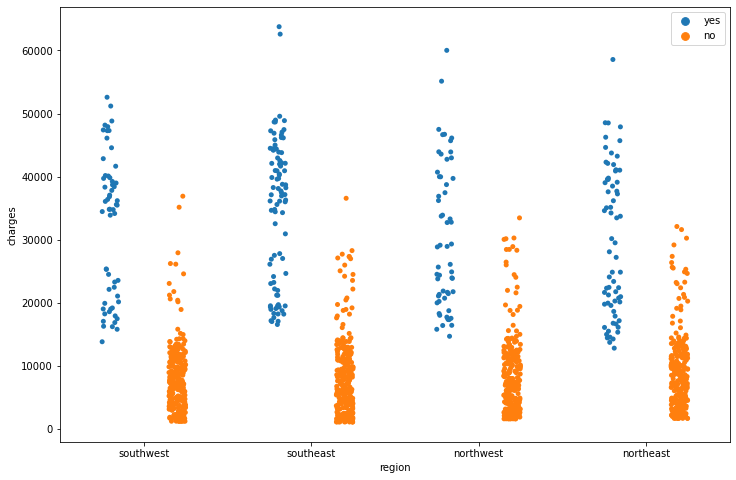

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sns.stripplot(data = df, x = "region", y = "charges", hue = "smoker", dodge=True)
plt.legend(loc='upper right')
plt.show()

Majority of the regions are similar in charges, except southeast has few outliners.

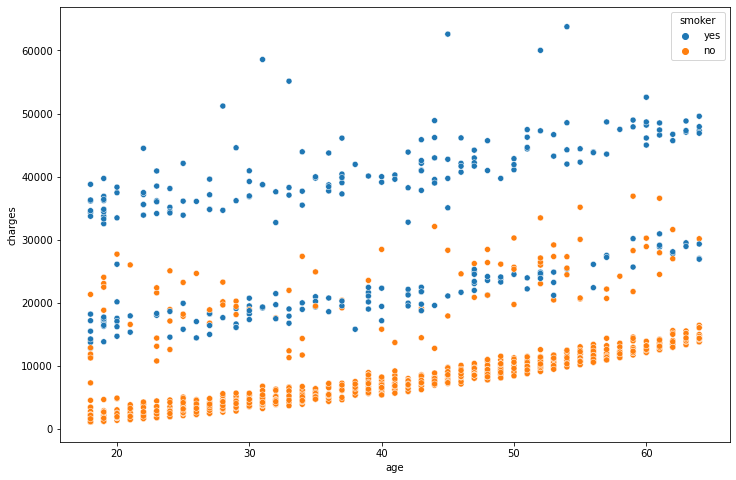

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data = df, x = "age", y = "charges", hue = "smoker")
plt.show()

Observations:

1. Medical charges increase with age

2. We can see three clusters of points, each of which seems to form a line with an increasing slope:

i. The first cluster consists of non-smokers who have relatively low medical charges compared to others.

ii. The second cluster contains a mix of smokers and non-smokers. It's possible that these are actually two distinct but overlapping clusters: "non-smokers with other medical issues" and "smokers without major medical issues".

iii. The final cluster consists of smokers with major medical issues that are possibly related to or worsened by smoking.

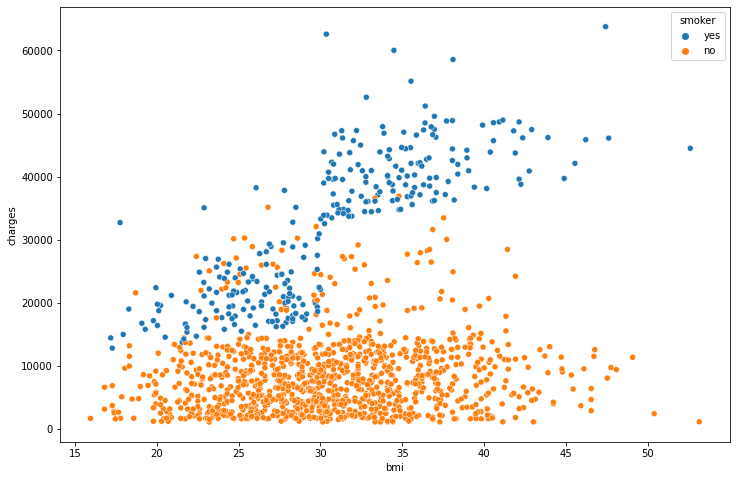

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data = df, x = 'bmi', y = 'charges', hue = 'smoker')
plt.show()

Medical charges seem to be significantly higher for smokers with a BMI greater than 30.

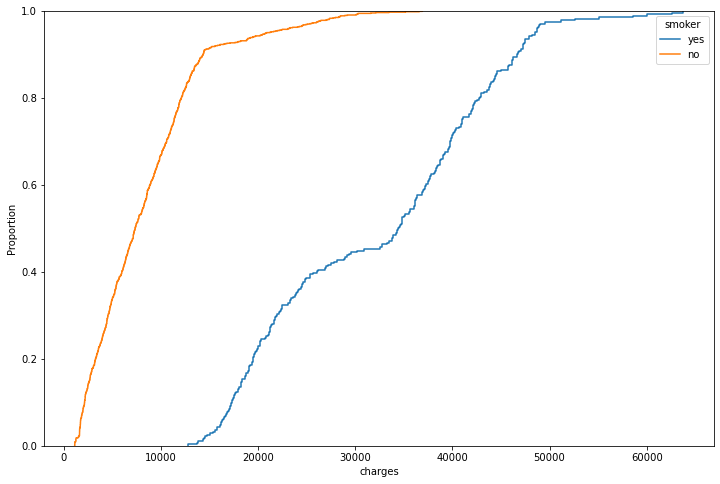

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sns.ecdfplot(data = df, x = "charges", hue = "smoker")
plt.show()

Observation:
Almost 67% of non-smokers have medical charges of 10,000 dollars or less. Whereas, for smokers, the charges start from nearly 13,000 dollars, and almost 55% of smokers have medical charges more than 30,000 dollars. 

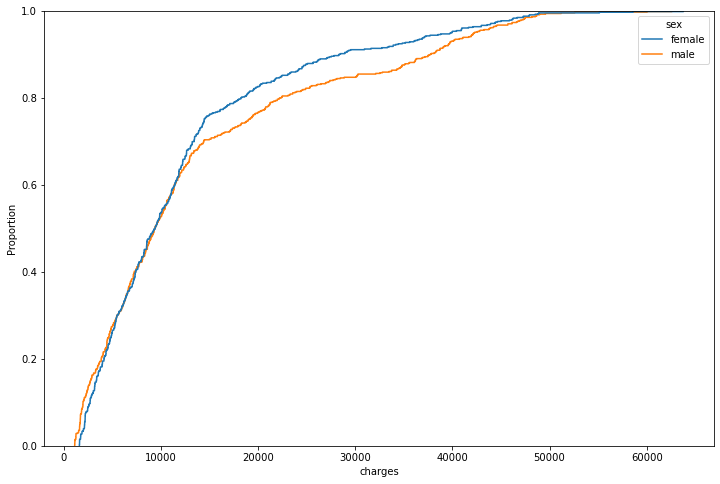

In [23]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sns.ecdfplot(data = df, x = "charges", hue = "sex")
plt.show()

Observation:
After ~60%, the charges of females seem to increase by a bit.

## 4. Modeling

In [24]:
df_orig = df.drop(['bmi_cat'], axis = 1)
df_orig.head()

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

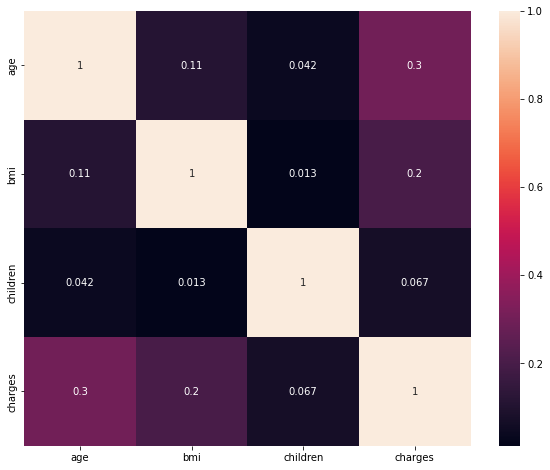

In [25]:
plt.figure(figsize=(10,8))
sns.heatmap(df_orig.corr(), annot=True)
plt.show()

In [26]:
scaler = StandardScaler()
df_orig[['age','bmi','children']] = scaler.fit_transform(df_orig[['age','bmi','children']])

In [27]:
df1 = pd.get_dummies(df_orig,columns=['sex','smoker','region'])
df1.head()

age       bmi  children      charges  sex_female  sex_male  smoker_no  \
0 -1.440418 -0.453160 -0.909234  16884.92400           1         0          0   
1 -1.511647  0.509422 -0.079442   1725.55230           0         1          1   
2 -0.799350  0.383155  1.580143   4449.46200           0         1          1   
3 -0.443201 -1.305052 -0.909234  21984.47061           0         1          1   
4 -0.514431 -0.292456 -0.909234   3866.85520           0         1          1   

   smoker_yes  region_northeast  region_northwest  region_southeast  \
0           1                 0                 0                 0   
1           0                 0                 0                 1   
2           0                 0                 0                 1   
3           0                 0                 1                 0   
4           0                 0                 1                 0   

   region_southwest  
0                 1  
1                 0  
2                 0  
3                 0  
4                 0

In [28]:
X = df1.drop("charges",axis='columns')
X

age       bmi  children  sex_female  sex_male  smoker_no  \
0    -1.440418 -0.453160 -0.909234           1         0          0   
1    -1.511647  0.509422 -0.079442           0         1          1   
2    -0.799350  0.383155  1.580143           0         1          1   
3    -0.443201 -1.305052 -0.909234           0         1          1   
4    -0.514431 -0.292456 -0.909234           0         1          1   
...        ...       ...       ...         ...       ...        ...   
1333  0.767704  0.050269  1.580143           0         1          1   
1334 -1.511647  0.206053 -0.909234           1         0          1   
1335 -1.511647  1.014490 -0.909234           1         0          1   
1336 -1.297958 -0.797524 -0.909234           1         0          1   
1337  1.551231 -0.261299 -0.909234           1         0          0   

      smoker_yes  region_northeast  region_northwest  region_southeast  \
0              1                 0                 0                 0   
1              0                 0                 0                 1   
2              0                 0                 0                 1   
3              0                 0                 1                 0   
4              0                 0                 1                 0   
...          ...               ...               ...               ...   
1333           0                 0                 1                 0   
1334           0                 1                 0                 0   
1335           0                 0                 0                 1   
1336           0                 0                 0                 0   
1337           1                 0                 1                 0   

      region_southwest  
0                    1  
1                    0  
2                    0  
3                    0  
4                    0  
...                ...  
1333                 0  
1334                 0  
1335                 0  
1336                 1  
1337                 0  

[1337 rows x 11 columns]

In [29]:
y = df1['charges']
y

0       16884.92400
1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
           ...     
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
1337    29141.36030
Name: charges, Length: 1337, dtype: float64

In [30]:
X_test, X_train, y_test, y_train = train_test_split(X, y, test_size = 0.25, random_state = 1234)

In [31]:
# Fit a linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test,y_test)

0.7323919910987776

In [32]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits = 5, test_size = 0.25, random_state = 1234)

lr_score=cross_val_score(lr, X, y, cv = 5)
print("Accuracy score for lr:",lr_score)
print("Average score for lr:",lr_score.mean())

Accuracy score for lr: [0.76148609 0.70651382 0.77741544 0.73269494 0.7555821 ]
Average score for lr: 0.7467384760760102


In [33]:
# Fit a RandomForestRegression model
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_scores = cross_val_score(rf, X_train, y_train, scoring = 'r2', cv = 5)
print("Accuracy scores for rf: ", rf_scores)
print("Average accuracy score for rf: ", rf_scores.mean())

Accuracy scores for rf:  [0.80148792 0.92981532 0.92487121 0.7583912  0.83280217]
Average accuracy score for rf:  0.849473563683639


In [34]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(random_state=1234),
            'params': {
                'criterion' : ['squared_error','friedman_mse'],
                'splitter': ['best','random']
            }
        },
        'ridge':{
            'model':Ridge(),
            'params':{
                'alpha':[1,2]
            }
            
        },
        'randomforest_regressor':{
            'model':RandomForestRegressor(random_state=1234),
            'params':{
                'n_estimators':[100, 150, 200],
                'max_depth': [1, 2, 3]
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits = 5, test_size = 0.25, random_state = 1234)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X_train, y_train)

model  best_score  \
0       linear_regression    0.758365   
1                   lasso    0.758447   
2           decision_tree    0.743671   
3                   ridge    0.758440   
4  randomforest_regressor    0.885950   

                                         best_params  
0                               {'normalize': False}  
1                {'alpha': 2, 'selection': 'cyclic'}  
2  {'criterion': 'friedman_mse', 'splitter': 'best'}  
3                                       {'alpha': 1}  
4              {'max_depth': 3, 'n_estimators': 200}

In [37]:
# Evaluate the model on the test data
from sklearn import metrics

rf = RandomForestRegressor(n_estimators = 200, max_depth = 3, random_state = 1234)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Root Mean Squared Error:", rmse)
print('Mean Squared Error (MSE):', mse)
print('R-squared (R2) Score:', r2)

Root Mean Squared Error: 4804.062534378773
Mean Squared Error (MSE): 23079016.8342218
R-squared (R2) Score: 0.8424793110648026


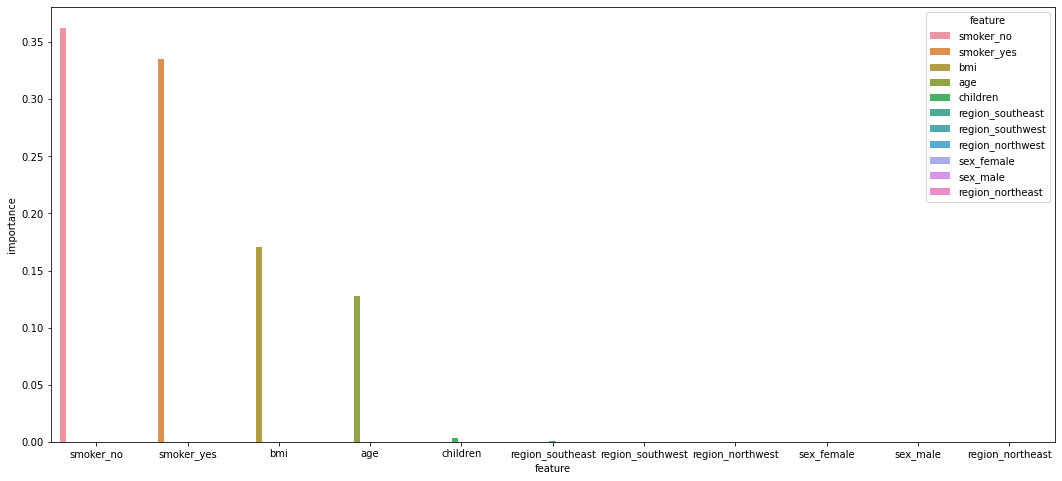

In [36]:
# Visualize the feature importances
importances = rf.feature_importances_
feature_names = X_train.columns.tolist()

feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(18, 8))
sns.barplot(data = feature_importances, x = 'feature', y = 'importance', hue = 'feature')
plt.show()

## Conclusion

The Root Mean Squared Error (RMSE) value of 4804.06 indicates that on average, the model's predicted charges values are off by $4804.06 from the actual charges values. The Mean Squared Error (MSE) value of 23079016.83 represents the average of the squared differences between the predicted and actual charges values. The R-squared (R2) score of 0.8424 indicates that approximately 84.24% of the variation in the charges can be explained by the features used in the model.

Overall, these evaluation metrics suggest that the Random Forest Regressor model has performed well in predicting the medical charges based on the provided dataset. Also we plotted a visual interpretation of the most important features in the dataset for predicting medical charges and it is found that smoker_yes is the most important feature in the dataset.

In conclusion, we can say that the Random Forest Regression model can effectively predict the medical charges based on the given dataset. However, further exploration and analysis can be done to improve the performance of the model and to gain more insights into the dataset.